### Correspondence Selection ###

The following process is used to automatically compile a training data set to be used in learning a shadow attenuation model. The output of the previous segmentation has provided us with 'patches' of surface that are likely a simliar material, and are spatially connected to each other - partly in the shade, and partly in the open. From those segments we can select a well distributed subset of pixels in the shade, then identify nearby pixels which we hope are the same material in the open.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pickle

lidar_import = np.load('data/lidar_data.npz')
intensity = lidar_import['intensity']
dem = lidar_import['dem']
shadow = lidar_import['shadow']

lidar_segment_import = pickle.load(open('data/lidar_segmentation.p', 'rb'))

#### Selection Amounts ####

Each 'correspondence' will consist of one pixel in the shade, and at least one pixel in the open. Selecting more than one pixel in the open allows for some flexibility in assessing the learned models later in the pipeline.

In [49]:
rng = np.random.default_rng(131071)

number_of_correspondences = 500
number_of_candidate_pairs = 5

# building a list of (region_id, pixel_index) pairs to build training data from
training_pixels_in_shade = []
for i in range(number_of_correspondences):
    region_id = rng.integers(1, len(lidar_segment_import)+1)
    pixel_index = rng.integers(0, len(lidar_segment_import[region_id]['shade']))
    training_pixels_in_shade.append((region_id, pixel_index))

#### Shadow Dilation ####

Experiments suggest that buffering the lidar-derived shadow map is beneficial. The primary reason for this is that the lidar and hyperspectral data do not align perfectly, and in some cases shaded pixels in the image fall just outside the estimated shadow locations. To avoid introducing these erroneous pixels into our training data in the next step, buffering the computed shadows and removing those pixels from consideration is a necessity.

In [50]:
dilation_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (12, 12))
shadow = cv.dilate(np.uint8(shadow), dilation_kernel).astype(bool)

shadow_pixels = np.where(shadow)
shadow_pixels = set(zip(shadow_pixels[0], shadow_pixels[1]))

for region_id in lidar_segment_import:
    for pixel in lidar_segment_import[region_id]['open']:
        if pixel in shadow_pixels:
            lidar_segment_import[region_id]['open'].remove(pixel)

#### Candidate Pixel Identification ####

Once we have a batch of randomly selected shadow pixels, we need to pair them up with pixels in the open. A search radius is specified to restrict the window examined for potential pairs. The operations below iterate over each training pixel in the shade and perform the following steps:  
* Identify all pixels in the open within the search radius having the same reigon ID
* Build a matrix of [z, intensity] values for each open pixel
* Find the *k* nearest candidate pixels to the current training pixel where *k* = `number_of_candidate_pairs`

**Note:** this part of the pipeline is highly customizable. In the below, only lidar attributes are used, and the squared-euclidean distance is applied to determine *nearness*. A number of other features (e.g. from the sepctral data), and other distance metrics could be utilized. In practical experiments the current configuration has provided reasonable training data sets.

In [51]:

# building a collection of the form { shade_pixel: possible_open_pixels[] }
training_data = {}
search_radius_in_pixels = 35
number_of_training_pixels_skipped = 0

for region_id, pixel_index in training_pixels_in_shade:
    
    training_pixel = lidar_segment_import[region_id]['shade'][pixel_index]

    search_window = []
    for row in range(training_pixel[0] - search_radius_in_pixels, training_pixel[0] + search_radius_in_pixels):
        for column in range(training_pixel[1] - search_radius_in_pixels, training_pixel[1] + search_radius_in_pixels):
            search_window.append((row,column))

    search_window = set(search_window)
    search_window = list(search_window.intersection(set(lidar_segment_import[region_id]['open'])))
    
    # matrix of observations in associated 'open' patch adjacent to training pixel
    candidate_data = np.array([[dem[pixel], intensity[pixel]] for pixel in search_window ])

    if candidate_data.shape[0] < number_of_candidate_pairs: 
        number_of_training_pixels_skipped += 1
        continue

    # scale feature values to candidate max to mitigate uneven weighting
    candidate_max = np.max(candidate_data, axis=0)
    candidate_data = candidate_data / candidate_max
    training_point = np.array([dem[training_pixel], intensity[training_pixel]])
    training_point = training_point / candidate_max

    # compute distances of candidate pixels from training pixel; select specified number of 
    # nearest pixels for inclusion in training output
    candidate_distances = np.sum((candidate_data - training_point) ** 2, axis=1)
    ascending_distance_indices = np.argsort(candidate_distances)
    
    # note the candidate data matrix will have one row per pixel in search window, so the sorted index 
    # can be used to identify the pixel location using the search_window as follows
    training_data[training_pixel] = []
    for candidate_index in ascending_distance_indices[:number_of_candidate_pairs]:
        training_data[training_pixel].append(search_window[candidate_index])

print('Selections made. ', number_of_training_pixels_skipped, ' training pixels were skipped over.')
pickle.dump(training_data, open('data/training_correspondences.p', 'wb'))

Selections made.  17  training pixels were skipped over.


[(315, 310), (629, 635), (597, 622), (310, 319), (15, 34), (655, 642), (131, 135), (614, 610), (653, 677), (656, 633)]
[(14, 13), (68, 68), (50, 46), (17, 31), (180, 176), (188, 196), (298, 296), (208, 203), (77, 62), (71, 53)]


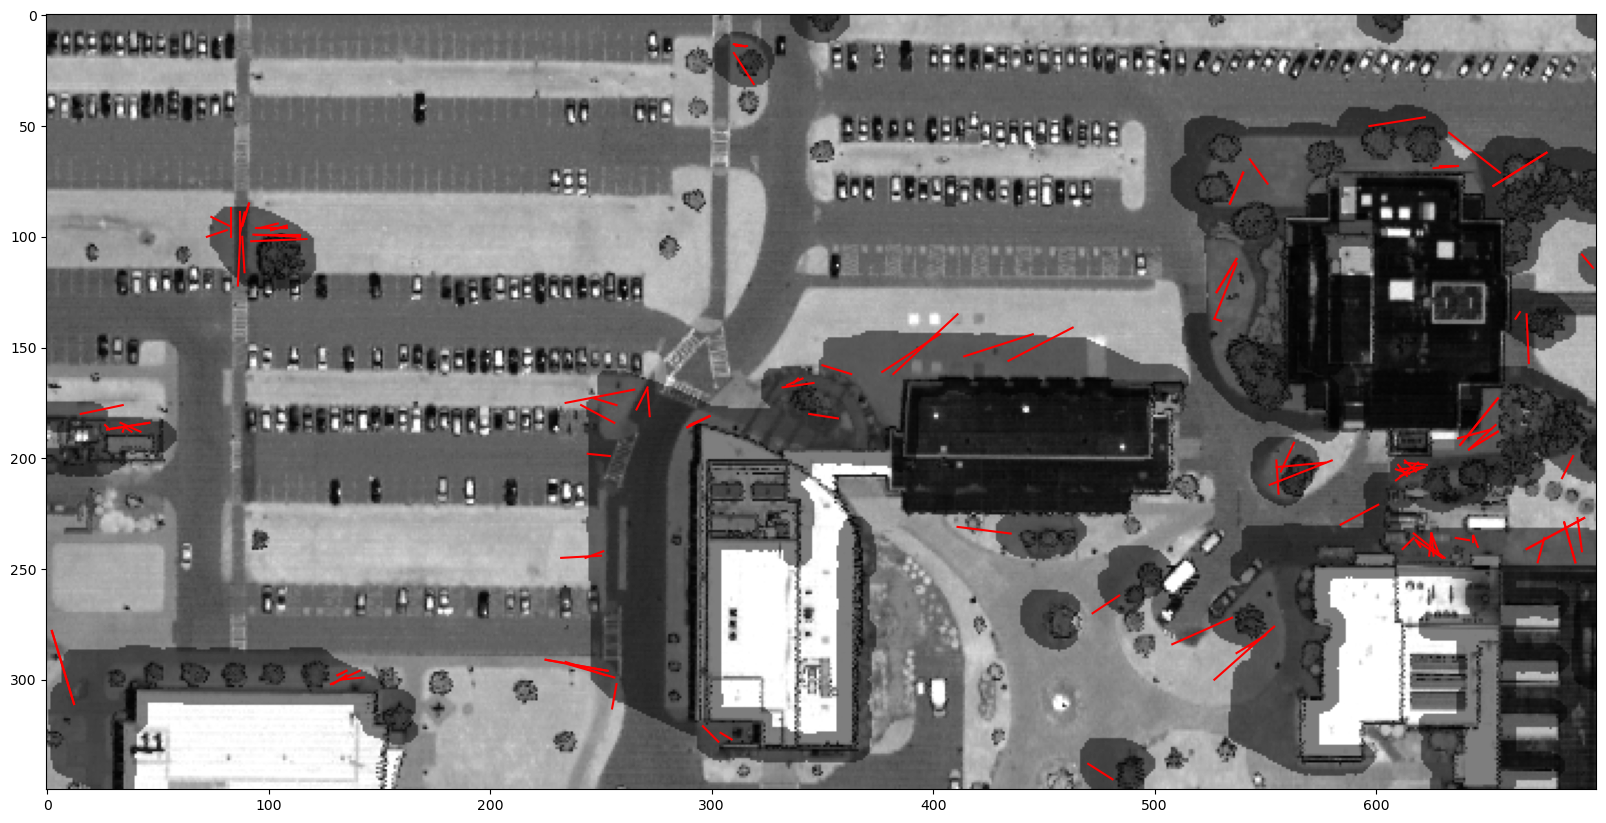

In [52]:
import random

num_examples = 120
training_keys = list(training_data.keys())
example_shadow_pixels = [ training_keys[i] for i in np.random.randint(0, len(training_keys), (num_examples)) ]

correspondence_x_vals = []
correspondence_y_vals = []

for i in range(num_examples):
    correspondence_x_vals.append((example_shadow_pixels[i][1], training_data[example_shadow_pixels[i]][0][1]))
    correspondence_y_vals.append((example_shadow_pixels[i][0], training_data[example_shadow_pixels[i]][0][0]))

print(correspondence_x_vals[:10])
print(correspondence_y_vals[:10])

shaded_intensity = intensity.copy()
for pixel in shadow_pixels:
    shaded_intensity[pixel] *= 0.5

plt.figure(figsize=(20,20))
plt.imshow(shaded_intensity, cmap='gray')
for i in range(num_examples):
    plt.plot(correspondence_x_vals[i], correspondence_y_vals[i], '-r')
plt.show()